Adapted from https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html#results

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()
def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [4]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

In [5]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


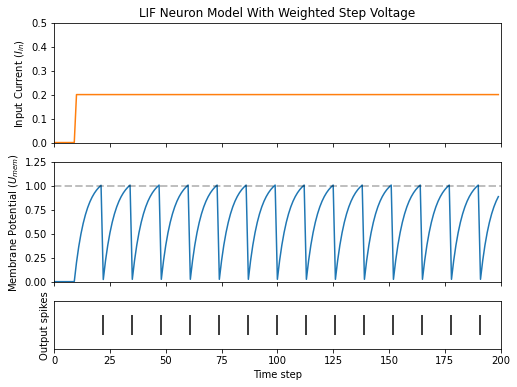

In [6]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

In [7]:
lif1 = snn.Leaky(beta=0.8)

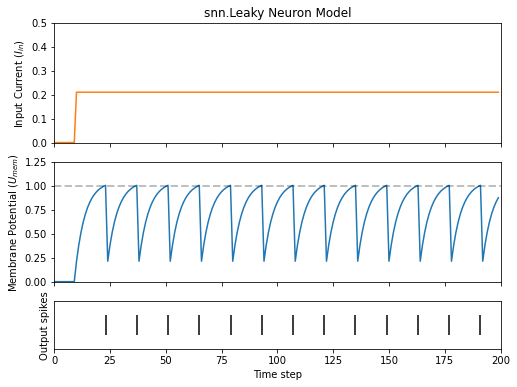

In [8]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

In [9]:
# layer parameters
num_inputs = 4
num_hidden = 2
num_outputs = 1
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [10]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

In [11]:
spk_in = spikegen.rate_conv(torch.rand((200, 4))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 4])


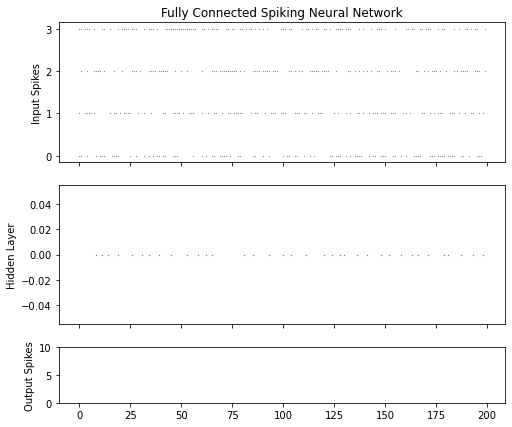

In [12]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

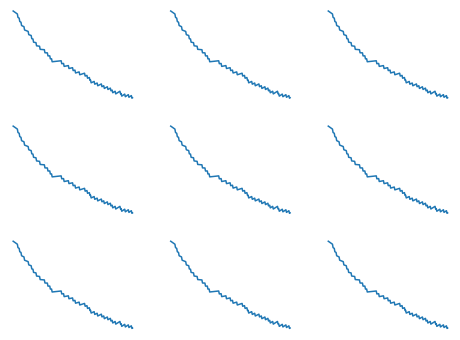

In [13]:
# plot membrane potential traces
splt.traces(mem2_rec, spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)

In [14]:
# dataloader arguments
#Note, modifying code so that it works with our downscaled problem, no promises! 

batch_size = 1
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
from torchvision import datasets, transforms

x_train = [[[0,0,0,0], 0], [[0,0,0,1], 0],[[0,0,1,0], 0], [[0,1,0,0], 0], [[1,0,0,0], 0], 
[[0,0,1,1], 0.5], [[0,1,0,1], 0.5], [[1,0,0,1], 0.5], [[1,0,1,0], 0.5], [[1,1,0,0], 0.5], 
[[0,1,1,1], 1],[[1,0,1,1], 1],[[1,1,0,1], 1],[[1,1,1,0], 1],[[1,1,1,1], 1]]

y_train = [0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,1,1,1,1,1]

x_test = x_train
y_test = y_train 

y_train = y_train * 100
x_train = x_train* 100


In [16]:
x_train

[[[0, 0, 0, 0], 0],
 [[0, 0, 0, 1], 0],
 [[0, 0, 1, 0], 0],
 [[0, 1, 0, 0], 0],
 [[1, 0, 0, 0], 0],
 [[0, 0, 1, 1], 0.5],
 [[0, 1, 0, 1], 0.5],
 [[1, 0, 0, 1], 0.5],
 [[1, 0, 1, 0], 0.5],
 [[1, 1, 0, 0], 0.5],
 [[0, 1, 1, 1], 1],
 [[1, 0, 1, 1], 1],
 [[1, 1, 0, 1], 1],
 [[1, 1, 1, 0], 1],
 [[1, 1, 1, 1], 1],
 [[0, 0, 0, 0], 0],
 [[0, 0, 0, 1], 0],
 [[0, 0, 1, 0], 0],
 [[0, 1, 0, 0], 0],
 [[1, 0, 0, 0], 0],
 [[0, 0, 1, 1], 0.5],
 [[0, 1, 0, 1], 0.5],
 [[1, 0, 0, 1], 0.5],
 [[1, 0, 1, 0], 0.5],
 [[1, 1, 0, 0], 0.5],
 [[0, 1, 1, 1], 1],
 [[1, 0, 1, 1], 1],
 [[1, 1, 0, 1], 1],
 [[1, 1, 1, 0], 1],
 [[1, 1, 1, 1], 1],
 [[0, 0, 0, 0], 0],
 [[0, 0, 0, 1], 0],
 [[0, 0, 1, 0], 0],
 [[0, 1, 0, 0], 0],
 [[1, 0, 0, 0], 0],
 [[0, 0, 1, 1], 0.5],
 [[0, 1, 0, 1], 0.5],
 [[1, 0, 0, 1], 0.5],
 [[1, 0, 1, 0], 0.5],
 [[1, 1, 0, 0], 0.5],
 [[0, 1, 1, 1], 1],
 [[1, 0, 1, 1], 1],
 [[1, 1, 0, 1], 1],
 [[1, 1, 1, 0], 1],
 [[1, 1, 1, 1], 1],
 [[0, 0, 0, 0], 0],
 [[0, 0, 0, 1], 0],
 [[0, 0, 1, 0], 0],
 [[0, 1, 0

In [141]:
# Create DataLoaders
from torch.utils.data import DataLoader
batch_size = 1
train_loader = DataLoader(x_train, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(x_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [142]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 4
        num_hidden = 2
        num_outputs = 1
        beta = 0.99
        
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [143]:
import numpy as np
loss = nn.MSELoss() #CrossEntropyLoss()

In [144]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
# constant beta for JJ sim

In [149]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(torch.Tensor(data))
    _, idx = output.sum(dim=1).max(0)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    #print_batch_accuracy(data, targets, train=True)
    #print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [151]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        #data = data.to(device)
        #targets = targets.to(device)

        # forward pass
        net.train()
        input_data = torch.Tensor(data)

        spk_rec, mem_rec = net(input_data)
        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step].float(), targets.float())

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            #test_data = test_data.to(device)
            #test_targets = test_targets.to(device)

            # Test set forward pass
            # net(input_data)
            test_spk, test_mem = net(torch.Tensor(test_data))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 117.64
Test Set Loss: 112.04


Epoch 0, Iteration 50
Train Set Loss: 22.69
Test Set Loss: 105.24


Epoch 0, Iteration 100
Train Set Loss: 45.49
Test Set Loss: 117.77


Epoch 0, Iteration 150
Train Set Loss: 114.67
Test Set Loss: 107.49


Epoch 0, Iteration 200
Train Set Loss: 21.68
Test Set Loss: 118.36


Epoch 0, Iteration 250
Train Set Loss: 44.56
Test Set Loss: 124.93


Epoch 0, Iteration 300
Train Set Loss: 112.60
Test Set Loss: 106.21


Epoch 0, Iteration 350
Train Set Loss: 21.44
Test Set Loss: 105.34


Epoch 0, Iteration 400
Train Set Loss: 41.68
Test Set Loss: 118.62


Epoch 0, Iteration 450
Train Set Loss: 100.72
Test Set Loss: 94.25


Epoch 0, Iteration 500
Train Set Loss: 22.88
Test Set Loss: 86.85


Epoch 0, Iteration 550
Train Set Loss: 40.66
Test Set Loss: 103.87


Epoch 0, Iteration 600
Train Set Loss: 105.41
Test Set Loss: 98.56


Epoch 0, Iteration 650
Train Set Loss: 22.80
Test Set Loss: 93.65


Epoch 0, Iteration 700
Train Set Los

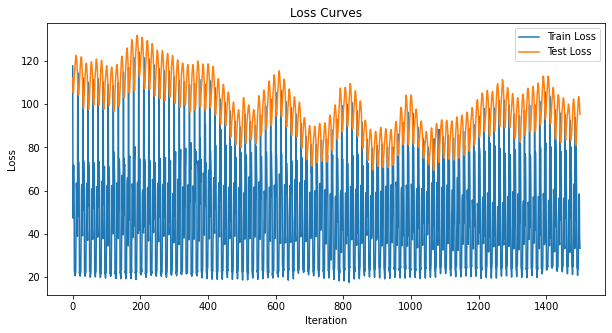

In [154]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

#try deeper network, try widening inputs, try time-encoding

In [ ]:
https://snntorch.readthedocs.io/en/latest/snntorch.backprop.html
https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss